# Heatwaves in Gallmannsegg
### Aim of this Notebook
The aim of this notebook is to play around with the hwmid value (REF).  The calculations are done with data for the location Gallmannsegg.

### General Remarks
The code partially based on [this repository](https://github.com/nicrie/HWMId/blob/main/hwmid.py). However, I just used pandas and numpy instead of xarray.

### Import used libs

In [1]:
import pandas as pd #used to handle dataframes
import folium #used for geographic visualisations
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display 
from datetime import datetime, date
from dateutil.rrule import rrule, DAILY, YEARLY

#helper functions
def get_window_set(window):
    return set(window)

### Data Source
The used datasource is https://dataset.api.hub.geosphere.at/app/frontend/raster/historical/spartacus-v2-1d-1km . The data are downloaded in CSV format. 

In [2]:
csv_file_path = 'SPARTACUS - Spatial Dataset for Climate in Austria Datensatz_19610101_20230701.csv'


# Create a folium map centered at the first coordinates in the DataFrame
#map_center = [df['lat'].iloc[0], df['lon'].iloc[0]]
#my_map = folium.Map(location=map_center, zoom_start=10)

# Add a marker for each coordinate pair in the DataFrame
#for lat, lon in zip(df['lat'], df['lon']):
#    folium.Marker([lat, lon]).add_to(my_map)

# Display the map directly in Jupyter Notebook
#display(my_map)

### Data investigation
Using just visual inspection, it seems like no missing values or outliers are in the used data set! Be aware to check that for each dataset.

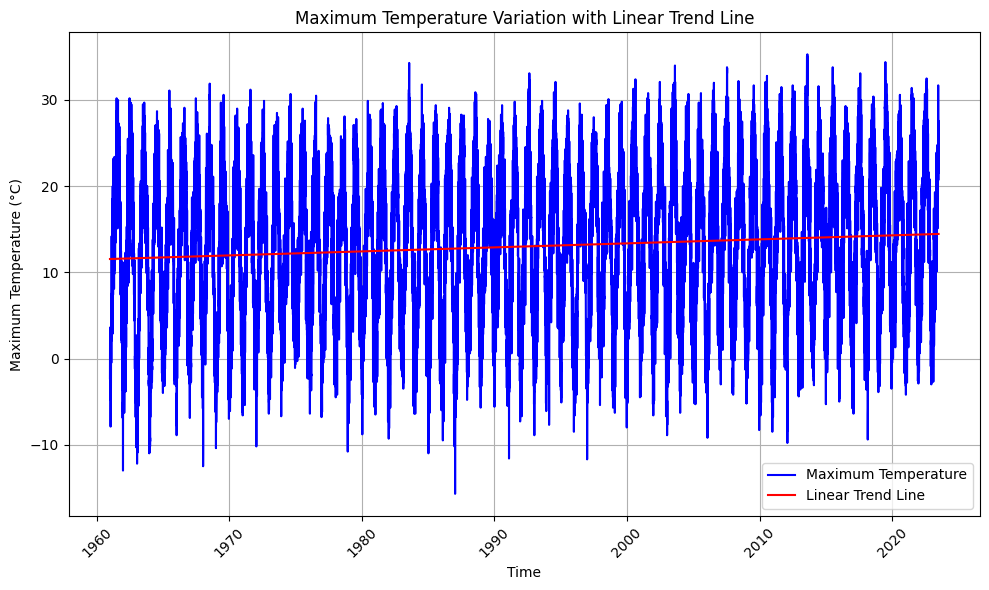

In [35]:

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert the timestamp to a pandas datetime object and set it as the index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# calculate linear trendline
coefficients = np.polyfit(np.arange(len(df)), df['TX [degree_Celsius]'], 1)
trend_line = np.polyval(coefficients, np.arange(len(df)))

# Plot the TX (maximum temperature) against the index with a linear trend line
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['TX [degree_Celsius]'], linestyle='-', color='b', label='Maximum Temperature')
plt.plot(df.index, trend_line, linestyle='-', color='r', label='Linear Trend Line')
plt.xlabel('Time')
plt.ylabel('Maximum Temperature (°C)')
plt.title('Maximum Temperature Variation with Linear Trend Line')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


## Heat Wave Magnitude Index
### Threshold for each calendar day of reference period
The threshold is based on the set of values 
$$A_d = \bigcup_{\text{Year}~~y}{\Big(\bigcup_{\text{Window Element}~~i}{T_{y,i}}\Big)}$$
, where the Window is a centered window of size 31 around day $d$ in each year $y$ of the reference time.
Therfore we start with obtaining the set of values as follows:

In [45]:
#Calculate Ad for each calendar Day
# definition of reference periode (Note: the dataset must contain the reference time and at least 15 days before and after that timespan)
ref_start_date = date(1981,1,1)
ref_end_date = date(2010,12,31)
windowsize = 31

#Will contain a numpy array with the set of values for each calendar day
Ad = {} #list of numpy arrays

#iterate over all days of a year use leap year to have also 29.02 :)
for day in rrule(DAILY, dtstart=date(2020,1,1), until=date(2021,1,1)): #Note: this year is actually not used, it can be any leap year.
     d = day.strftime("%m-%d")
     values = []
     # iterating over the years of the reference timespan
     for year in rrule(YEARLY, dtstart=ref_start_date, until=ref_end_date):
          y = year.strftime("%Y")
          if(d == "02-29" and int(y) % 4 != 0): 
               d = "03-01"

          current_date = pd.to_datetime(datetime.strptime(f"{y}-{d}", "%Y-%m-%d"), utc=True)
          windowvalues = df.loc[(df.index >= current_date - pd.Timedelta(days=windowsize//2)) & (df.index <= current_date + pd.Timedelta(days=windowsize//2))]
          values.append(windowvalues['TX [degree_Celsius]'].values)

     Ad[d] = np.vstack(values)


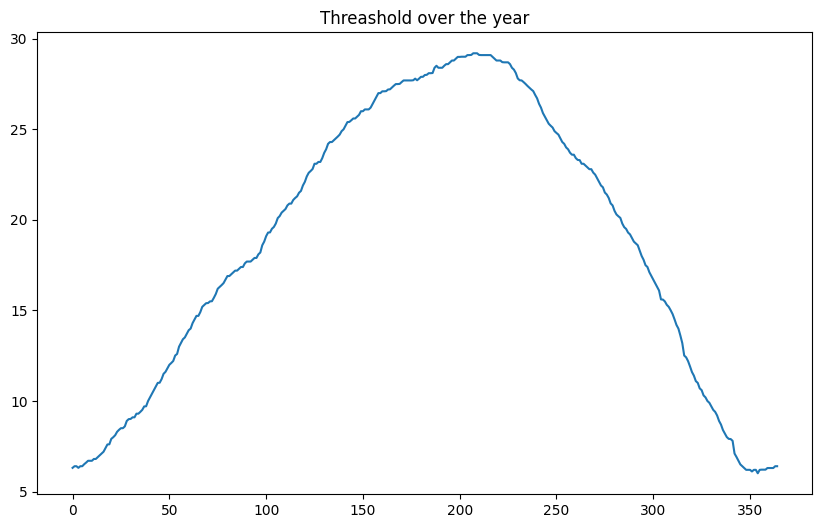

In [46]:
ThreasholdOfd = {} #list of the calculated threasholds

for key, value in Ad.items():
   ThreasholdOfd[key] = np.percentile(value.flatten(), 90)

plt.figure(figsize=(10, 6))
plt.title("Threashold over the year")
plt.plot(range(len(ThreasholdOfd)),ThreasholdOfd.values())


#add threashold to datafram
df['Calendar_Day'] = df.index.strftime('%m-%d')
df['Heatwave_Threshold'] = df['Calendar_Day'].map(ThreasholdOfd)


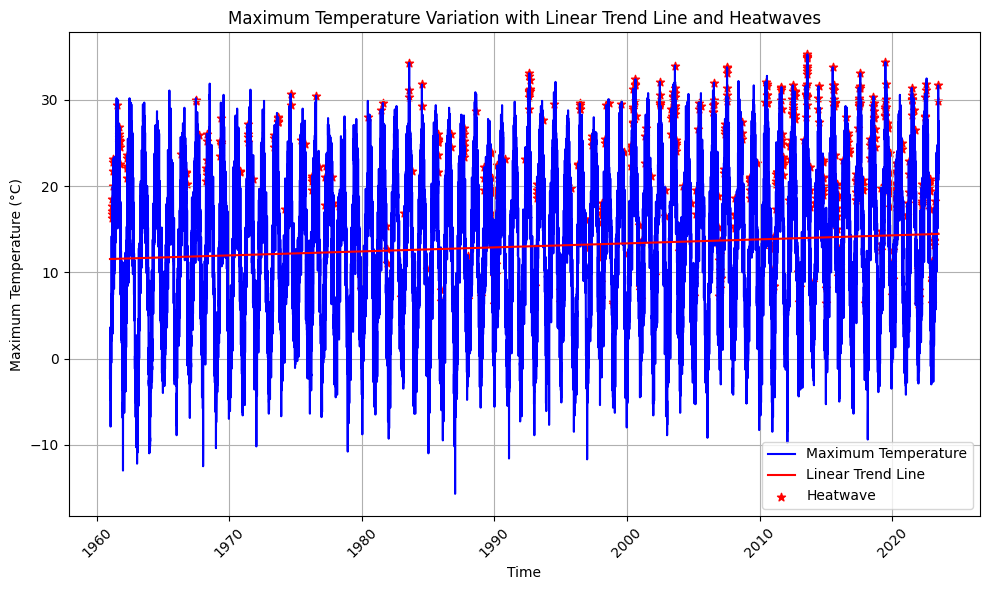

In [37]:
# Check if the temperature exceeds the heatwave threshold for at least 3 consecutive days
heatwave_duration = 3
heatwave_mask = df['TX [degree_Celsius]'] > df['Heatwave_Threshold']
heatwave_mask = heatwave_mask.rolling(window=f'{heatwave_duration}D').sum() >= heatwave_duration

# Plot the TX (maximum temperature) against the index with a linear trend line
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['TX [degree_Celsius]'], linestyle='-', color='b', label='Maximum Temperature')
coefficients = np.polyfit(np.arange(len(df)), df['TX [degree_Celsius]'], 1)
trend_line = np.polyval(coefficients, np.arange(len(df)))
plt.plot(df.index, trend_line, linestyle='-', color='r', label='Linear Trend Line')
plt.xlabel('Time')
plt.ylabel('Maximum Temperature (°C)')
plt.title('Maximum Temperature Variation with Linear Trend Line and Heatwaves')
plt.grid(True)
plt.xticks(rotation=45)

# Plot the heatwaves as red markers on the temperature plot
heatwave_indices = df[heatwave_mask.values].index
plt.scatter(heatwave_indices, df.loc[heatwave_indices, 'TX [degree_Celsius]'], color='r', marker='*', label='Heatwave')
plt.legend()

plt.tight_layout()
plt.show()

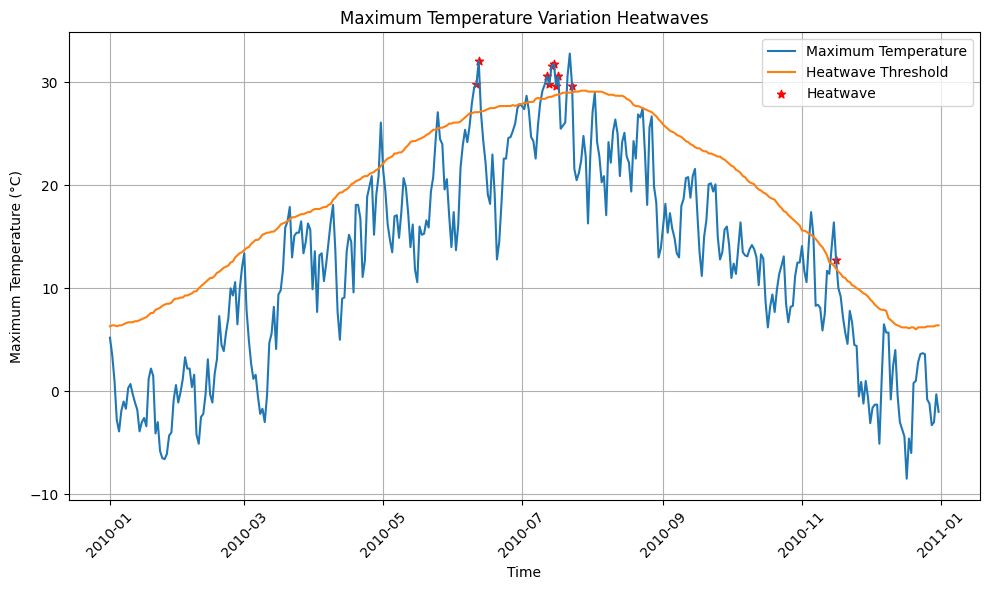

In [55]:
df['Year'] = df.index.strftime('%Y')
df2 = df[df["Year"] == "2010"]

heatwave_duration = 3
heatwave_mask = df2['TX [degree_Celsius]'] > df2['Heatwave_Threshold']
heatwave_mask = heatwave_mask.rolling(window=f'{heatwave_duration}D').sum() >= heatwave_duration

# Plot the TX (maximum temperature) against the index with a linear trend line
plt.figure(figsize=(10, 6))
plt.plot(df2.index, df2['TX [degree_Celsius]'], linestyle='-', label='Maximum Temperature')
plt.plot(df2.index, df2['Heatwave_Threshold'], linestyle='-',  label='Heatwave Threshold')
coefficients = np.polyfit(np.arange(len(df)), df['TX [degree_Celsius]'], 1)
trend_line = np.polyval(coefficients, np.arange(len(df)))
plt.xlabel('Time')
plt.ylabel('Maximum Temperature (°C)')
plt.title('Maximum Temperature Variation Heatwaves')
plt.grid(True)
plt.xticks(rotation=45)

# Plot the heatwaves as red markers on the temperature plot
heatwave_indices = df2[heatwave_mask.values].index
plt.scatter(heatwave_indices, df2.loc[heatwave_indices, 'TX [degree_Celsius]'], color='r', marker='*', label='Heatwave')
plt.legend()

plt.tight_layout()
plt.show()